<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a>
- <a href='#imports'>Import and install required libraries</a>
- <a href='#setting_fitting'>Setting of fitting</a> 
- <a href='#run_fit'>Running the fit</a>
 - <a href='#results'>Showing the results</a>

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the model of 
the [QENSlibrary](https://github.com/QENSlibrary/QENSmodels) corresponding to a 
combination of a jump translational diffusion with an
isotropic rotational diffusion to perform some 
fits using [bumps](https://github.com/bumps/bumps).
</div>

The **reference data** were generated using the above model with the following parameters: 
- D = 0.145 AA$^2\times$meV,
- Residence time = 1 meV$^-1$,
- Radius = 1.10 AA 
- D_rot = 0.125 meV.
                 
The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data were sampled randomly from a Poisson distribution.

There is no background. 

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [20]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps

 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.

In [21]:
# Name of Python script containing the model
model_file = "model_fit_JumpDifIsoRot.py"

In [22]:
%%writefile $model_file
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'JumpDiffIsoRot_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'JumpDiffIsoRot_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resTime=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwWaterTeixeira(x, q, scale, center, D, resTime, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, D=0.1, resTime=0.5, radius=1., DR=0.1, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0,1)
    Mq.resTime.range(0,5)
    Mq.radius.range(0,3)
    Mq.DR.range(0,2)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D
        QT = Mq.resTime
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.D = QD
        Mq.resTime = QT
        Mq.radius = QR
        Mq.DR = QDR
    M.append(Mq)
        
problem = FitProblem(M)

Overwriting model_fit_JumpDifIsoRot.py


<h3> Choice of minimizer for bumps </h3>

In [14]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

RHJvcGRvd24oZGVzY3JpcHRpb249dSdNaW5pbWl6ZXI6JywgaW5kZXg9NCwgb3B0aW9ucz17J1F1YXNpLU5ld3RvbiBCRkdTJzogJ25ld3RvbicsICdSYW5kb20gTGluZXMgKGV4cGVyaW1lbnTigKY=


<h3> Setting for running bumps </h3>

In [24]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='running_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

# /Users/celinedurniak/anaconda/envs/mynewenv/lib/python2.7/site-packages/bumps/cli.py model_fit_JumpDifIsoRot.py --fit=newton --steps=100 --store=QENS
-- Model 0 
.D = 0.1 in [0,1]
.DR = 0.1 in [0,2]
.center = 0 in [-0.1,0.1]
.q = 0.2
.radius = 1 in [0,3]
.resTime = 0.5 in [0,5]
.scale = 1000 in [0,100000]

[chisq=29.238(18), nllf=5862.2]
-- Model 1 
.D = 0.1 in [0,1]
.DR = 0.1 in [0,2]
.center = 0 in [-0.1,0.1]
.q = 0.4
.radius = 1 in [0,3]
.resTime = 0.5 in [0,5]
.scale = 1000 in [0,100000]

[chisq=39.628(18), nllf=7945.33]
-- Model 2 
.D = 0.1 in [0,1]
.DR = 0.1 in [0,2]
.center = 0 in [-0.1,0.1]
.q = 0.6
.radius = 1 in [0,3]
.resTime = 0.5 in [0,5]
.scale = 1000 in [0,100000]

[chisq=59.931(18), nllf=12016.1]
-- Model 3 
.D = 0.1 in [0,1]
.DR = 0.1 in [0,2]
.center = 0 in [-0.1,0.1]
.q = 0.8
.radius = 1 in [0,3]
.resTime = 0.5 in [0,5]
.scale = 1000 in [0,100000]

[chisq=89.575(18), nllf=17959.7]
-- Model 4 
.D = 0.1 in [0,1]
.DR = 0.1 in [0,2]
.center = 0 in [-0.1,0.1]
.q = 1
.ra

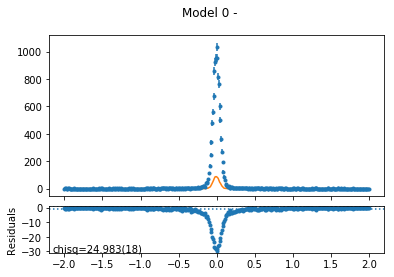

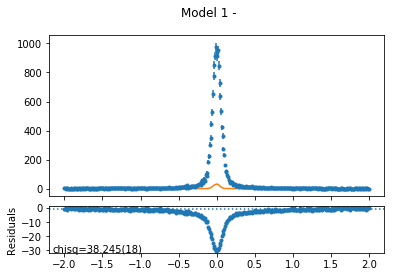

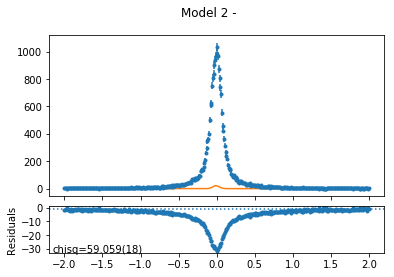

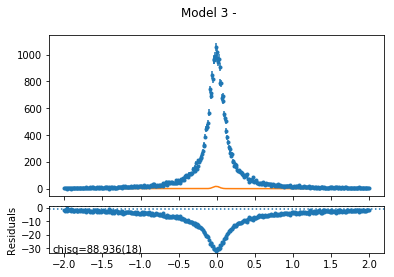

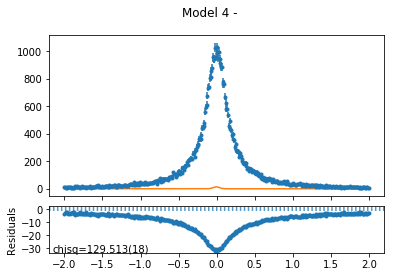

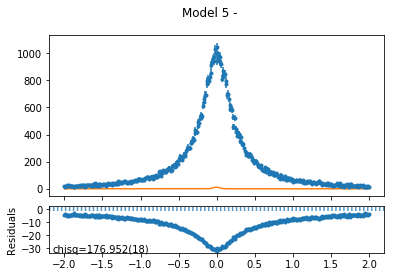

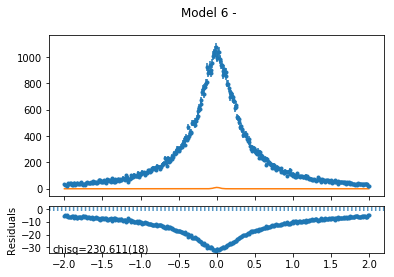

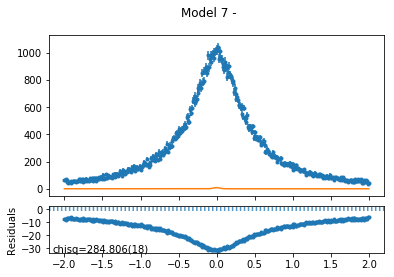

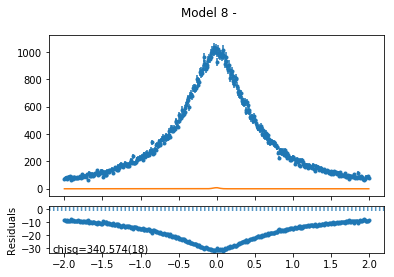

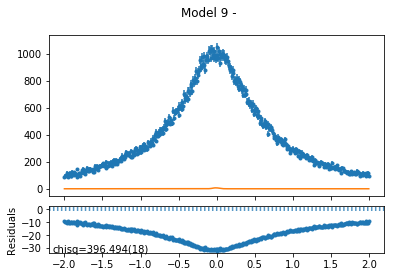

In [25]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [26]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

D 0.834231515878553
DR 0.433042744974663
center 0.0999999999999999
radius 1.09142640114479
resTime 0.488325538751124
scale 1000.00001771011
center 0.0766034417524622
scale 1000.00001660056
center 0.0508687478772948
scale 1000.00001652581
center 0.0374150887998423
scale 1000.00001624925
center 0.0290410473929464
scale 1000.00001586434
center 0.0233365306601468
scale 1000.00001542614
center 0.0192094628554405
scale 1000.00001496014
center 0.0160899937177581
scale 1000.00001447717
center 0.0136574216764066
scale 1000.00001398649
center 0.0117176882510766
scale 1000.00001349717
-- Model 0 
.D = 0.834232 in [0,1]
.DR = 0.433043 in [0,2]
.center = 0.1 in [-0.1,0.1]
.q = 0.2
.radius = 1.09143 in [0,3]
.resTime = 0.488326 in [0,5]
.scale = 1000 in [0,100000]

[chisq=24.983(18), nllf=5009.12]
-- Model 1 
.D = 0.834232 in [0,1]
.DR = 0.433043 in [0,2]
.center = 0.0766034 in [-0.1,0.1]
.q = 0.4
.radius = 1.09143 in [0,3]
.resTime = 0.488326 in [0,5]
.scale = 1000 in [0,100000]

[chisq=38.245(18),

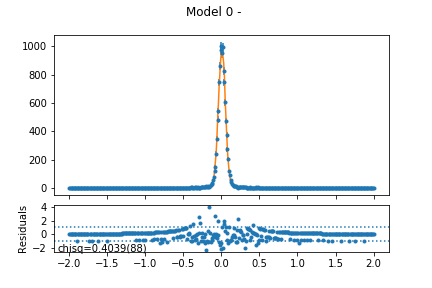

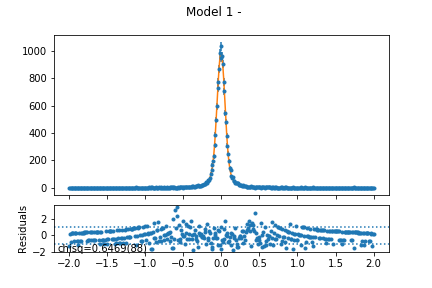

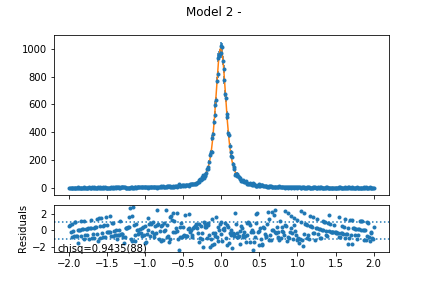

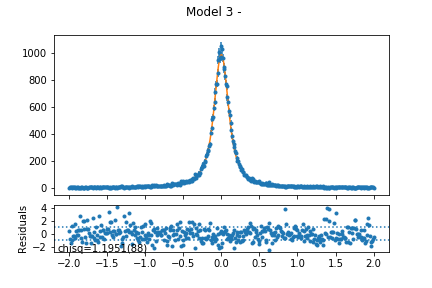

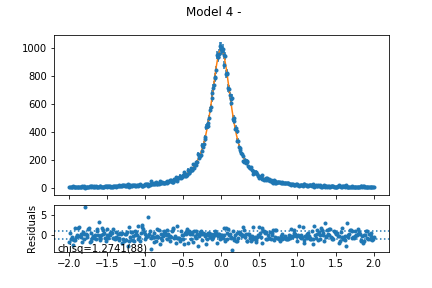

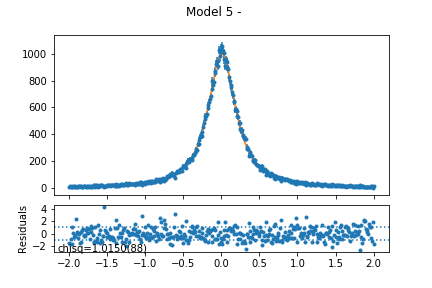

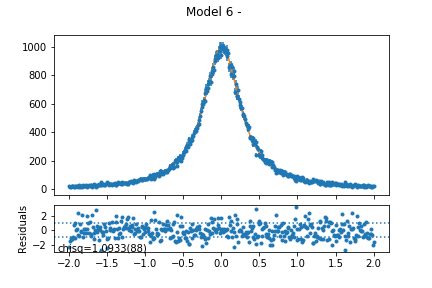

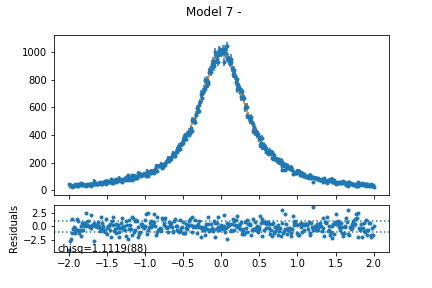

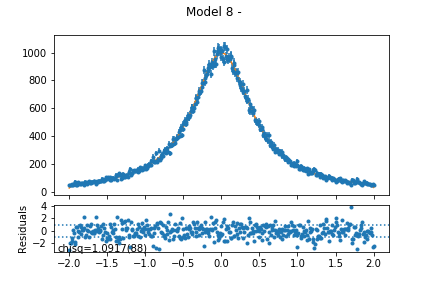

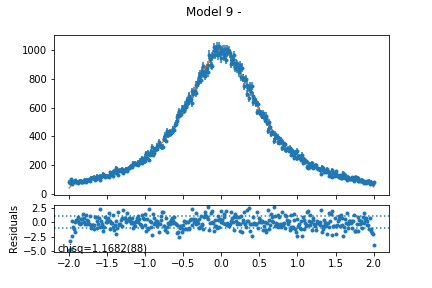

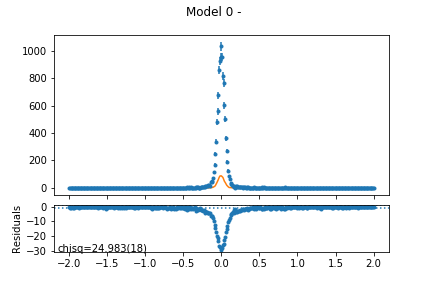

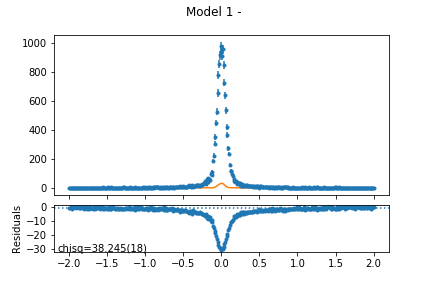

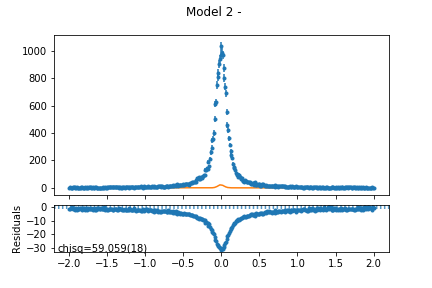

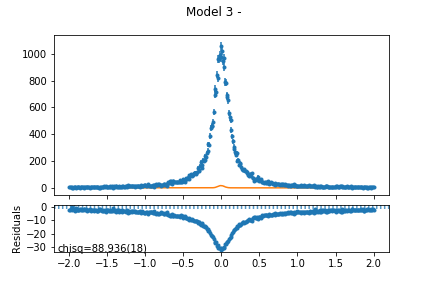

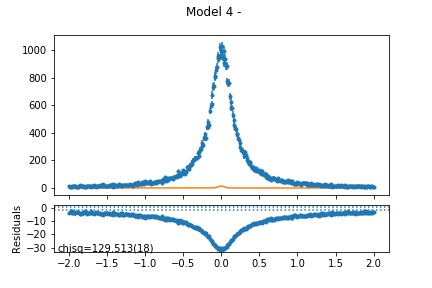

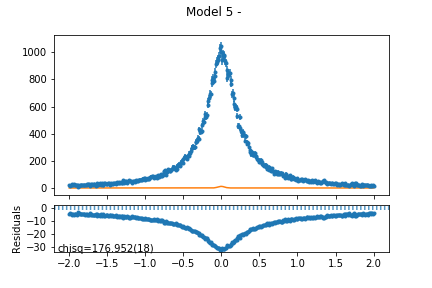

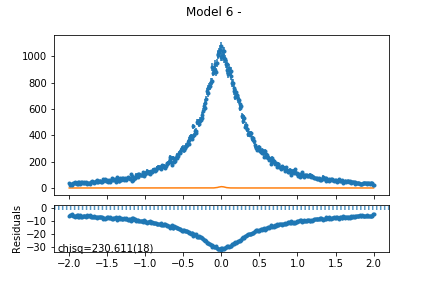

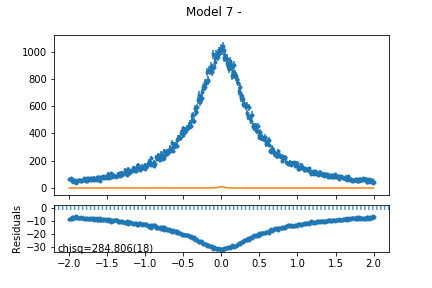

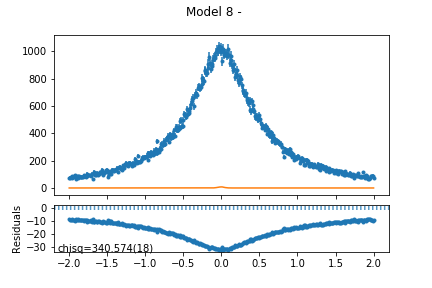

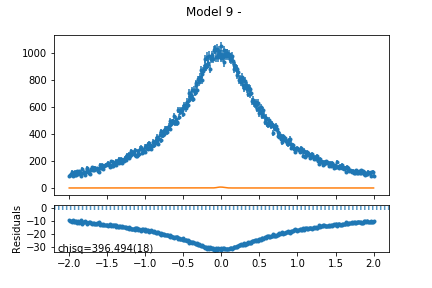

In [27]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))